In [1]:
# TODO Currently accesses .pos files from local directory. Must change to download from Zenodo when available
# PUT WHAT VERSION THE PAPER WAS RUN WITH!

# Zachary Katz
# zachary_katz@mines.edu
# November 2024

"""
Make and save the catalog of Whillans Stick Slip Events from .pos files, 
available from Earthscope at LINK. Keep the .pos files in the same folder
structure they were downloaded as, and set the top level directory as the
variable dir below.

v1.0 01 November 2024
    Clean catalog creation using Catalog.py
    Outputs Events, EventStartTimes, and NoData folders
"""

# Imports
import os
import logging

import src.Catalog.Catalog as Catalog

# %load_ext line_profiler


################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]
#stas= ["la01", "gz01","gz03","gz04"]
year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]
year_arr = [["2013"]]

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event
hr_offset = 0 # Offset in hours to extend beyond initial detection

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 

# fmt: on
########################## User Defined Variables ##############################
################################################################################


# Helper functions
def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [3]:
# Make Catalog

# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)
    picks.lls_detection(window, slide)
    sorted_list = picks.on_off_list()
    no_data = picks.no_data_csv(min_stas, sorted_list)

    merged_df = picks.merge()
    merged = Catalog.Events(merged_df)
    threshold = merged.pick_events(sorted_list, active_stas=min_stas, hr_off=hr_offset)

    catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)
    save_dir = (
        f"./Events{min_stas}stasLorentzian/{years[0]}_{years[-1]}Events{min_stas}stas"
    )
    Catalog.save_catalog(catalog, save_dir)

2024-11-19 14:57:59 __main__ INFO: Creating Dataframe for la01
2024-11-19 14:58:23 __main__ INFO: Interpolating la01
2024-11-19 14:58:26 src.Catalog.Catalog INFO: 2013-02-02 14:52:00 2013-02-02 14:52:45 0 days 00:00:45
2024-11-19 14:58:48 __main__ INFO: Creating Dataframe for la02
2024-11-19 14:59:20 __main__ INFO: Interpolating la02
2024-11-19 14:59:22 src.Catalog.Catalog INFO: 2013-01-26 04:42:00 2013-01-26 04:42:45 0 days 00:00:45
2024-11-19 14:59:22 src.Catalog.Catalog INFO: 2013-01-26 05:06:15 2013-01-26 05:08:00 0 days 00:01:45
2024-11-19 14:59:23 src.Catalog.Catalog INFO: 2013-01-26 05:08:45 2013-01-26 05:09:30 0 days 00:00:45
2024-11-19 14:59:24 src.Catalog.Catalog INFO: 2013-02-02 07:59:45 2013-02-02 08:00:30 0 days 00:00:45
2024-11-19 14:59:27 src.Catalog.Catalog INFO: 2013-02-26 17:16:00 2013-02-26 17:18:00 0 days 00:02:00
2024-11-19 14:59:31 src.Catalog.Catalog INFO: 2013-03-28 17:17:30 2013-03-28 17:19:30 0 days 00:02:00
2024-11-19 14:59:34 src.Catalog.Catalog INFO: 2013-0

In [4]:
start_time_save = f"./EventStartTime{min_stas}stas"
name = f"{years[0]}EventStartTime{min_stas}stas"
folders = [
    f"./Events{min_stas}stasLorentzian/{years[0]}_{years[-1]}Events{min_stas}stas"
]
Catalog.event_start_time(folders, start_time_save, name)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

merged.merged.to_csv("./merged2013.txt", sep="\t")

### RUN FROM HERE IF FOLDERS OF DESIRED EVENTS AND CUT LENGTHS ALREADY MADE

In [2]:
# Load merged dataframe
import src.Catalog.Catalog as Catalog

merged = pd.read_csv("./merged2013.txt", sep="\t")
merged = Catalog.Events(merged)

In [9]:
pd.set_option("display.max_rows", None)
%whos

Variable        Type        Data/Info
-------------------------------------
Catalog         module      <module 'src.Catalog.Cata<...>/src/Catalog/Catalog.py'>
active_stas     int         2
cull_dist       float       0.1
cull_time       int         30
dir             str         /mnt/d/csrs_2024/all
hr_offset       int         0
logging         module      <module 'logging' from '/<...>.11/logging/__init__.py'>
loglevel        str         INFO
max_gap_len     int         120
merged          Events      <src.Catalog.Catalog.Even<...>object at 0x7f86380e5290>
min_stas        int         2
os              module      <module 'os' (frozen)>
pd              module      <module 'pandas' from '/h<...>ages/pandas/__init__.py'>
plot_bool       bool        False
plt             module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
set_log_level   function    <function set_log_level at 0x7f86fc51b880>
slide           int         5
stas            list        n=48
window          in

In [2]:
# Hour offset
hr_off = 3

rows_off = int(hr_off * 3600 / 15)
temp = merged.merged["event"].values.copy()
for i in range(len(merged.merged["event"][:])):
    if merged.merged["event"][i] == 1:
        for j in range(1, rows_off):
            if i + j < len(merged.merged["event"]):
                temp[i + j] = 1
            if i - j > 0:
                temp[i - j] = 1
merged.merged["event"] = temp

In [27]:
year = 2013
catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)
save_dir = f"./Events{min_stas}stasLorentzian/{year}_{year}Events{min_stas}stas"
Catalog.save_catalog(catalog, save_dir)

In [29]:
start_time_save = f"./EventStartTimeLorentzian{min_stas}stas"
name = f"{year}EventStartTime{min_stas}stas"
folders = [f"./Events{min_stas}stasLorentzian/{year}_{year}Events{min_stas}stas"]
Catalog.event_start_time(folders, start_time_save, name)

In [53]:
def lorentzian(x, A, x0, gamma):
    """Lorentzian Function For Fitting "Spectral" Peaks

    Parameters
    ----------
    x : list
        data to fit
    A : float
        amplitude_
    x0 : float
        offset
    gamma : float
        impuksitivity

    Returns
    -------
    list
        Evaluated Lorentzian
    """
    return A / (1 + ((x - x0) / gamma) ** 2)


def gaussian(x, A, x0, sigma):
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

In [31]:
from scipy.optimize import curve_fit
import datetime

x_dats = []
y_dats = []
# onvert time to seconds
for i in range(len(catalog)):
    times = pd.to_datetime(catalog[i]["time"])
    time_arr = [
        datetime.datetime(
            time.year, time.month, time.day, time.hour, time.minute, time.second
        )
        for time in times
    ]

    secs = [time.timestamp() for time in time_arr]
    x_data = [sec - secs[int(len(secs) / 2)] for sec in secs]

    y_data = catalog[i]["ressum"].values
    x_dats.append(x_data)
    y_dats.append(y_data)

/tmp/ipykernel_69621/3338818131.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  times =  pd.to_datetime(catalog[i]["time"])


In [57]:
st = 0
ed = 10
initial_guess = [5, 0, 3000]
gamma_fits = []
a_fits = []

sigma_fits = []

for x_data, y_data in zip(x_dats[:], y_dats[:]):
    popt, pcov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)
    (
        A_fit,
        x0_fit,
        gamma_fit,
    ) = popt
    gamma_fits.append(gamma_fit)
    a_fits.append(A_fit)

    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    (
        A_fit,
        x0_fit,
        sigma_fit,
    ) = popt
    sigma_fits.append(sigma_fit)
    # print(f"Fitted Parameters:\n A = {A_fit:.3f}, x0 = {x0_fit:.3f}, gamma = {gamma_fit:.3f}")
    # fig, ax = plt.subplots()
    # ax.plot(x_data, y_data,color="red", label="Data")
    # ax.plot(x_data, lorentzian(x_data, *popt),color='black',label="Lorentzian")
    # ax.plot(x_data, gaussian(x_data, *popt),color='blue',label="Gaussian")
    # ax.legend()

In [33]:
# Load tides at event times
import src.Tides.Tides as Tides

tide_dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"
year = "2013"

# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(
    f"./EventStartTimeLorentzian2stas/{year}EventStartTime{min_stas}stas.txt", sep="\t"
)
ev_data["ev_time"] = df["EventStartTime"]

# Load no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv(f"./no_data_{min_stas}stas.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff

In [35]:
# Tides at event times
times_to_calculate_tide = ev_data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]
tides = Tides.Tide(tide_mod, tide_dir)
for lat, lon, place in zip(lats, lons, places):
    print(lat, lon, place)
    ev_data[f"tide_event_time_{place}"] = tides.tidal_elevation(
        [lon], [lat], dates
    ).data.T[0]

-84.2986 -164.5206 gz05


499
499


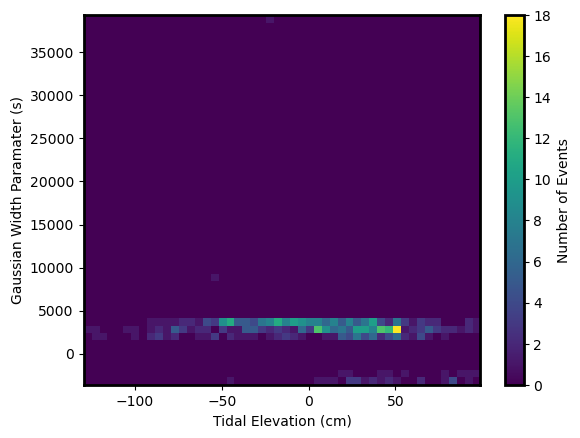

In [59]:
# Plot tides and slip times
print(len(ev_data["tide_event_time_gz05"]))
print(len(gamma_fits))
fig, ax = plt.subplots()
col = ax.hist2d(ev_data["tide_event_time_gz05"], sigma_fits, bins=(50, 50))
# ax.set_ylim(0,4000)
ax.set_xlabel("Tidal Elevation (cm)")
ax.set_ylabel("Gaussian Width Paramater (s)")

# Add colorar and label to fig
cbar = plt.colorbar(col[3], ax=ax, label="Number of Events")

/tmp/ipykernel_69621/392368543.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Colormap
/tmp/ipykernel_69621/392368543.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


Error in callback <function _draw_all_if_interactive at 0x7f7043681940> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

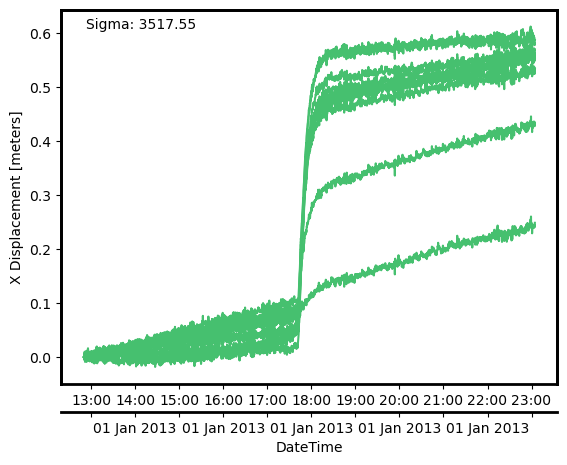

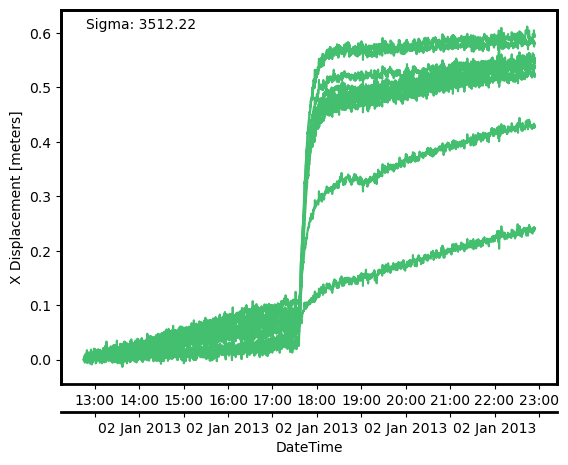

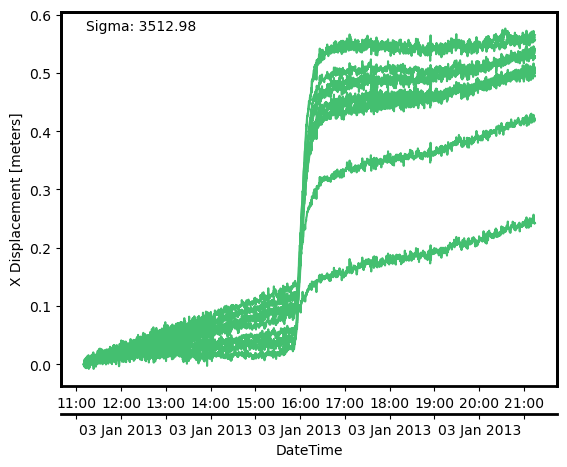

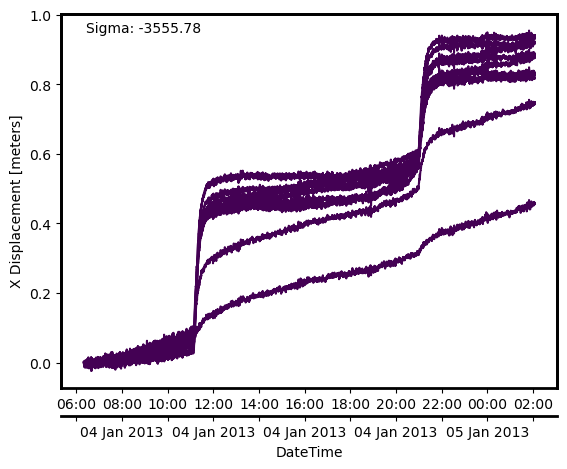

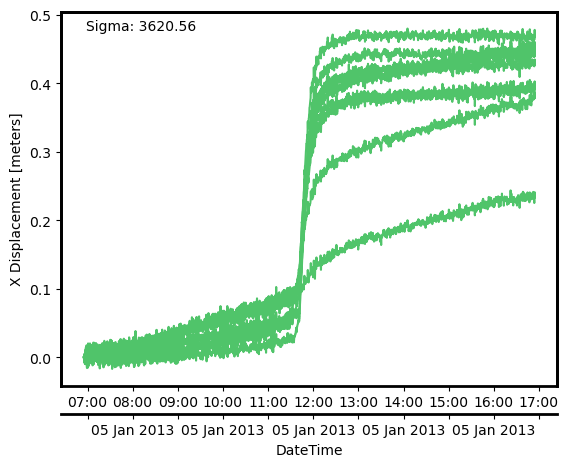

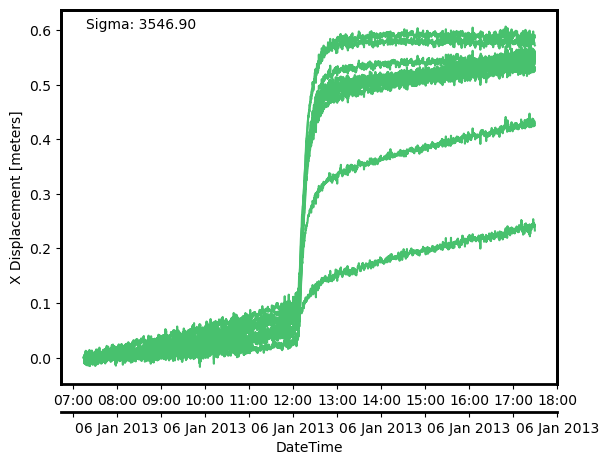

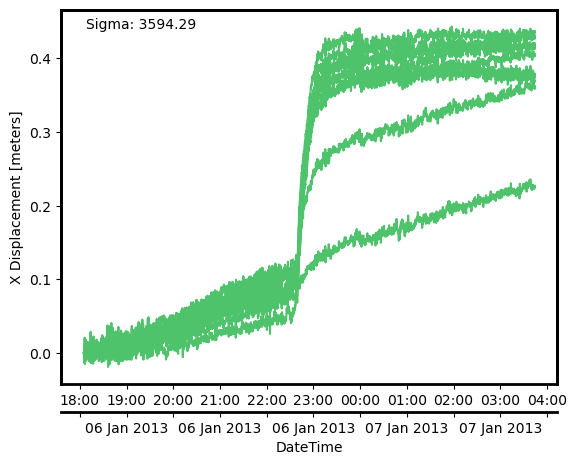

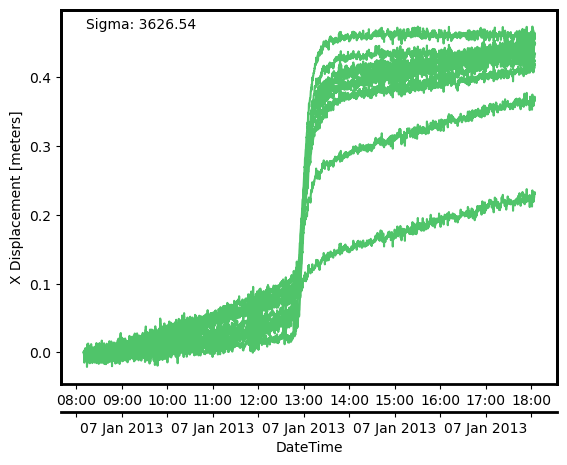

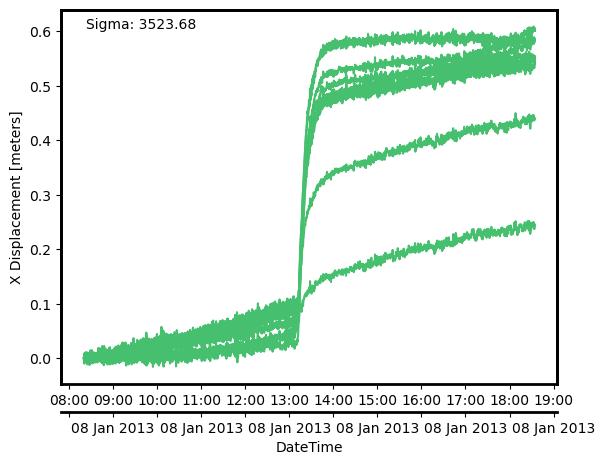

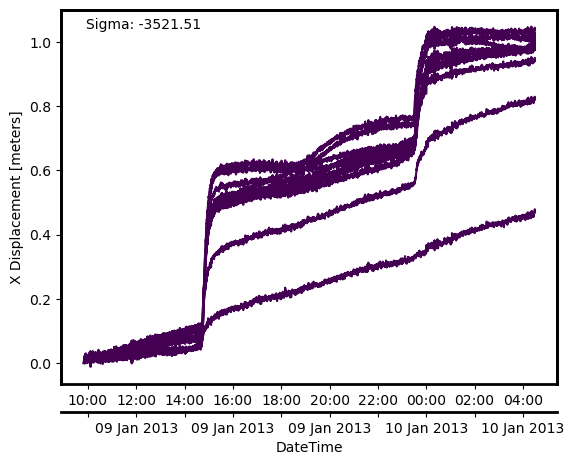

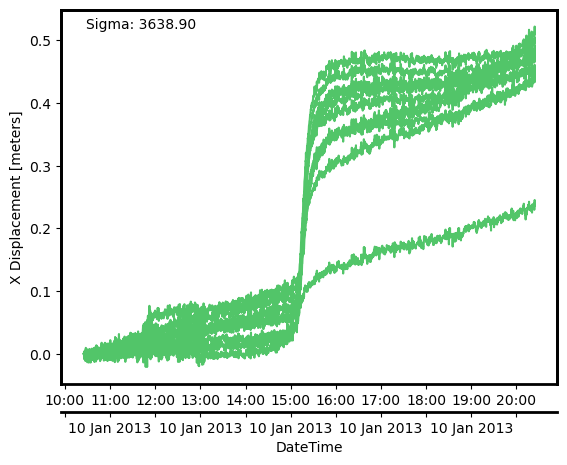

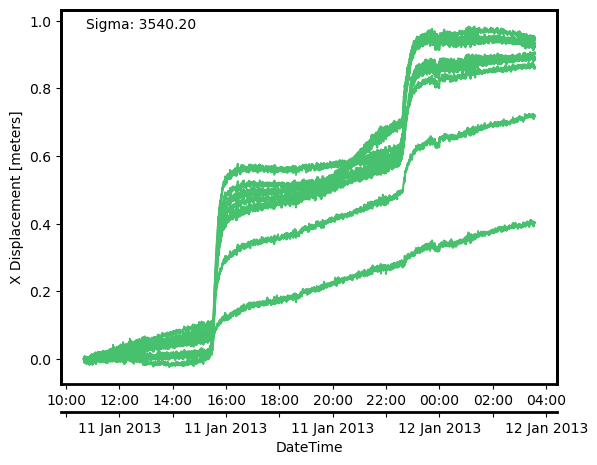

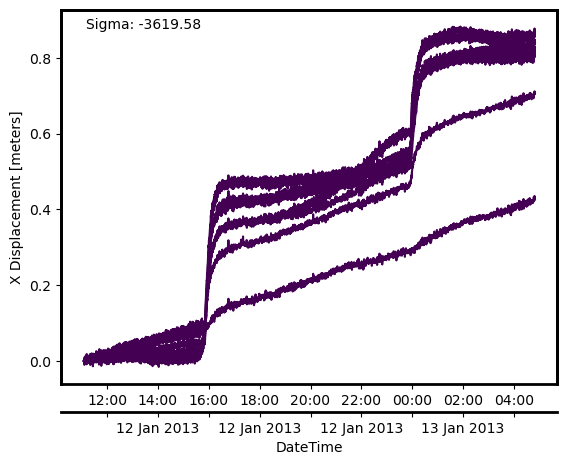

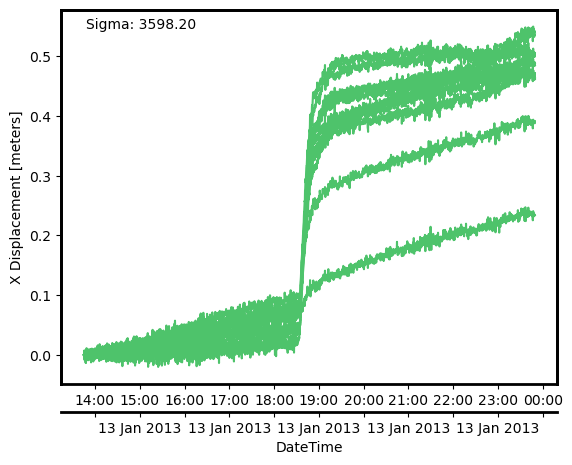

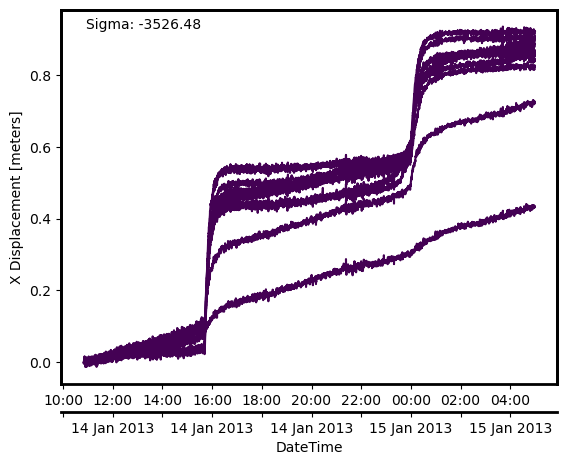

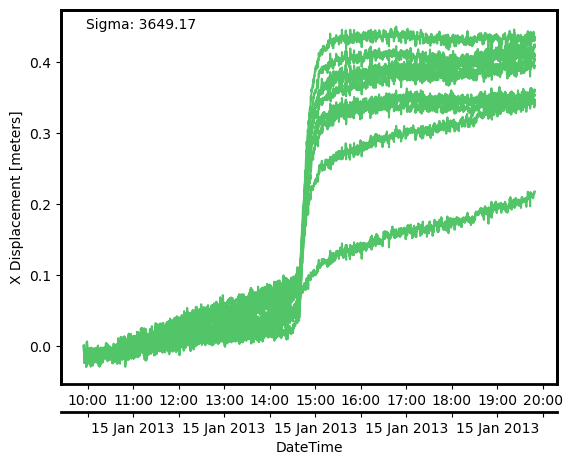

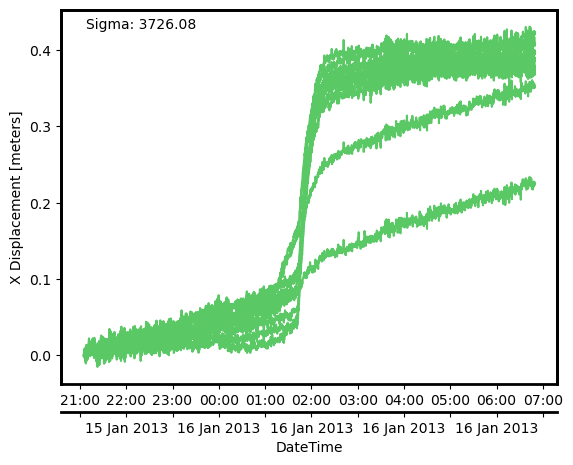

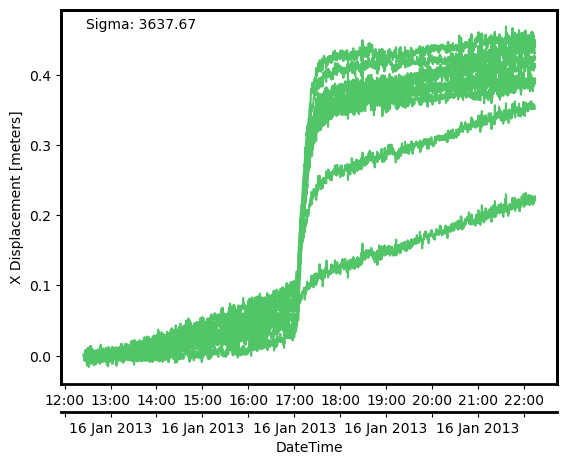

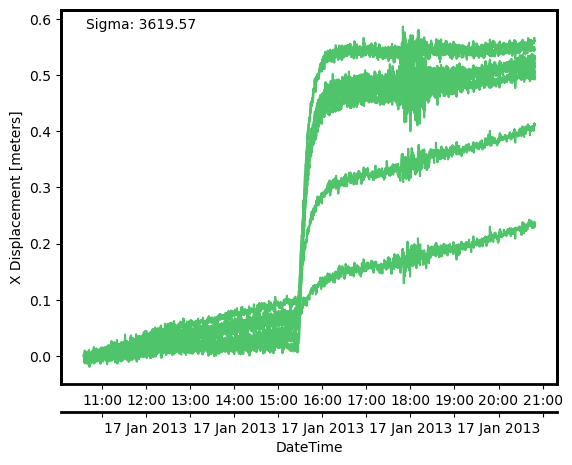

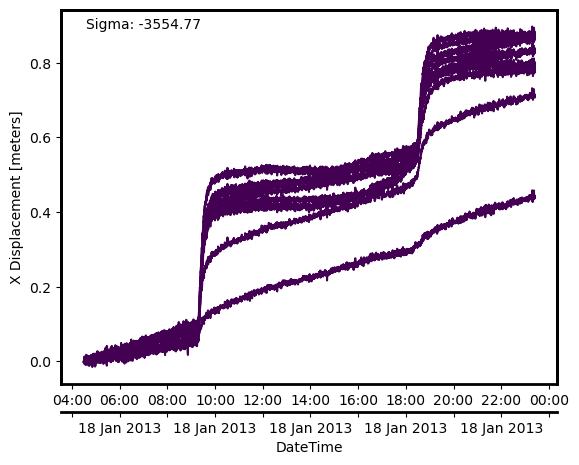

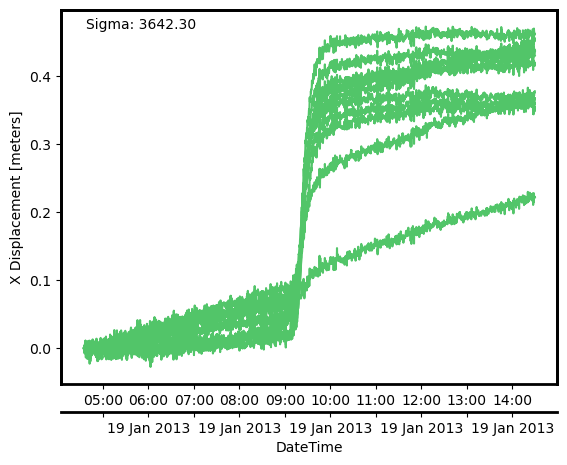

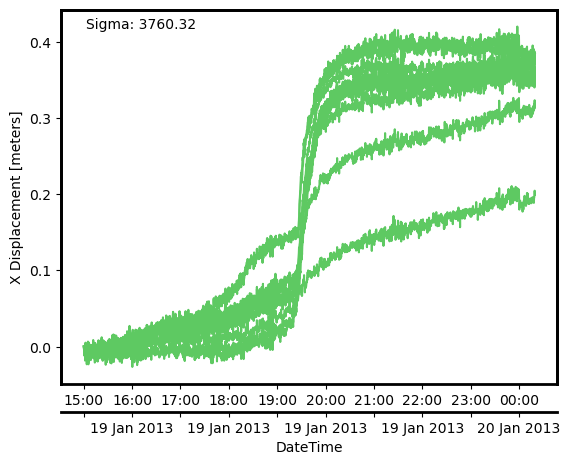

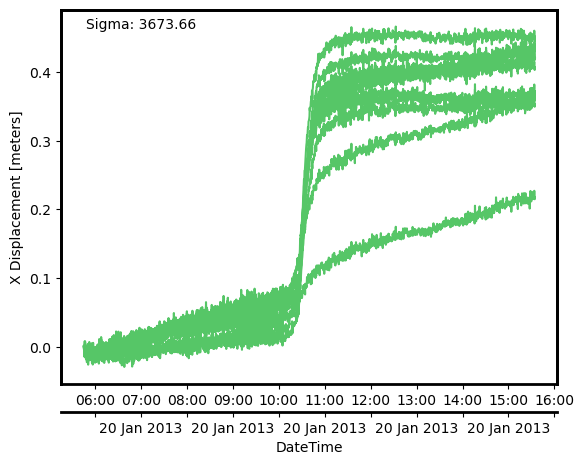

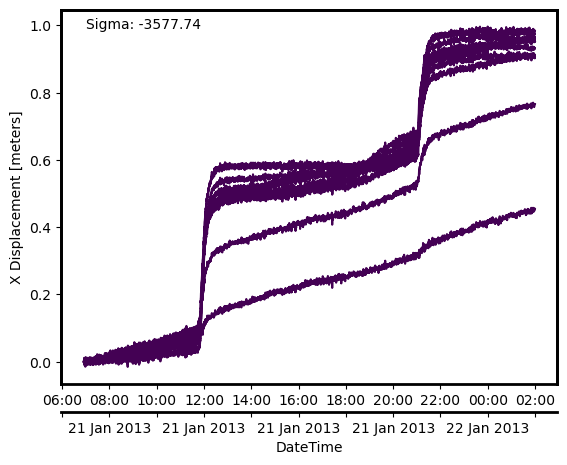

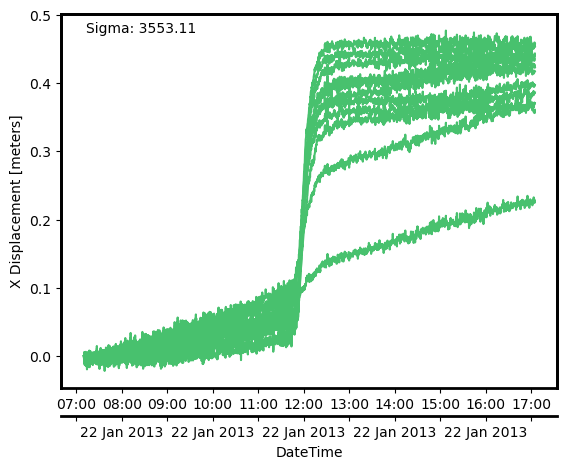

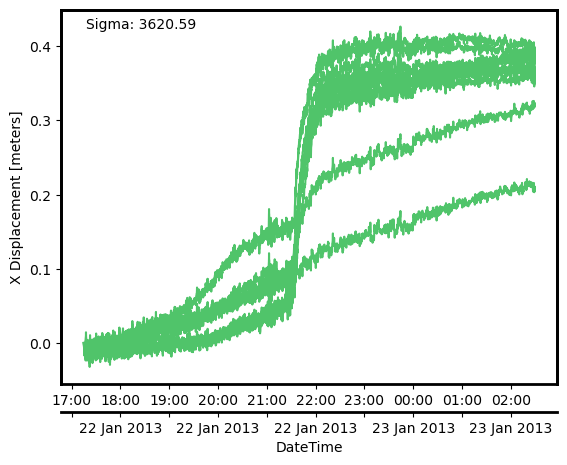

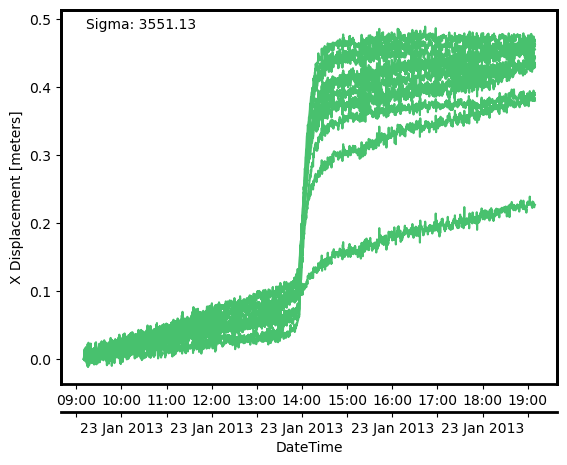

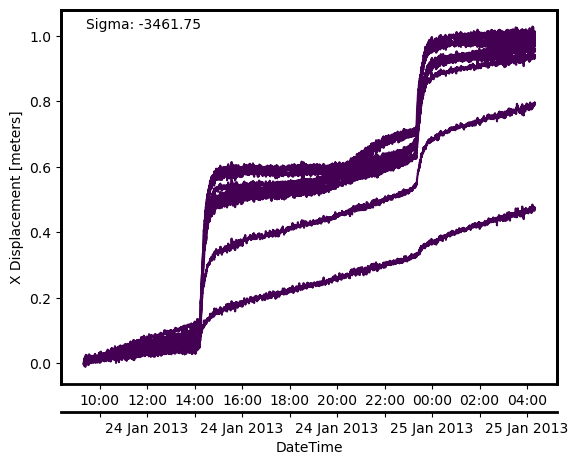

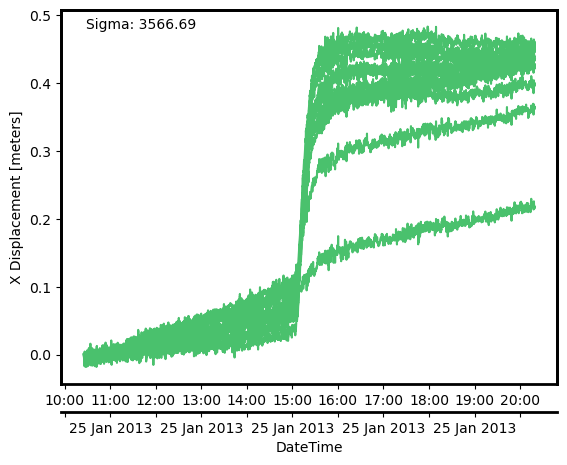

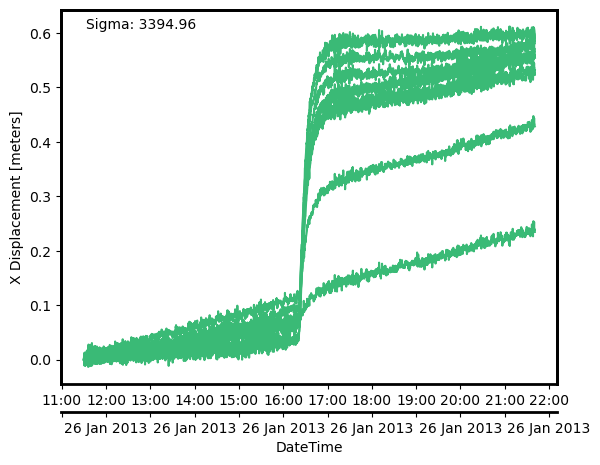

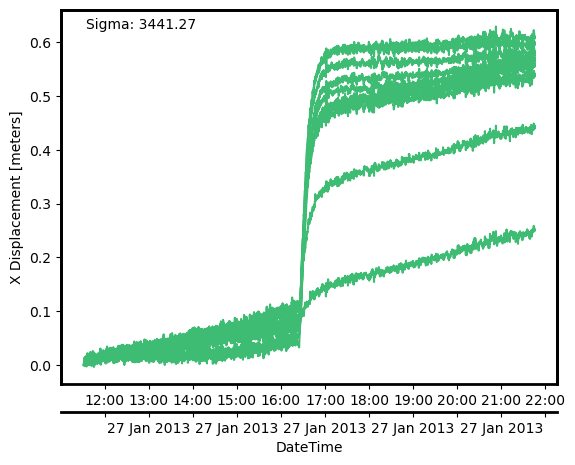

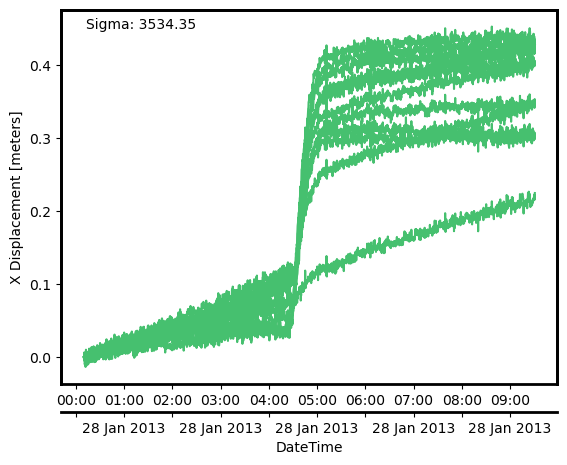

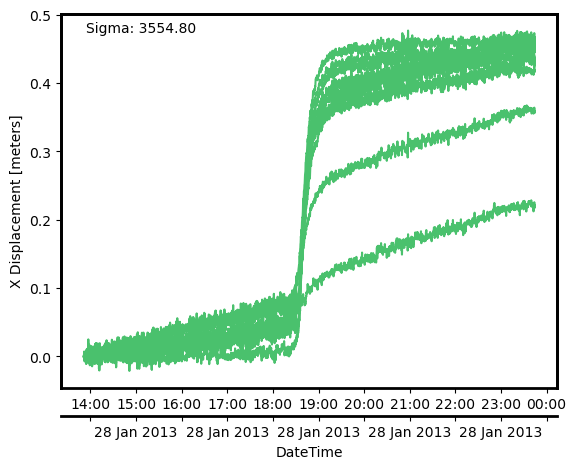

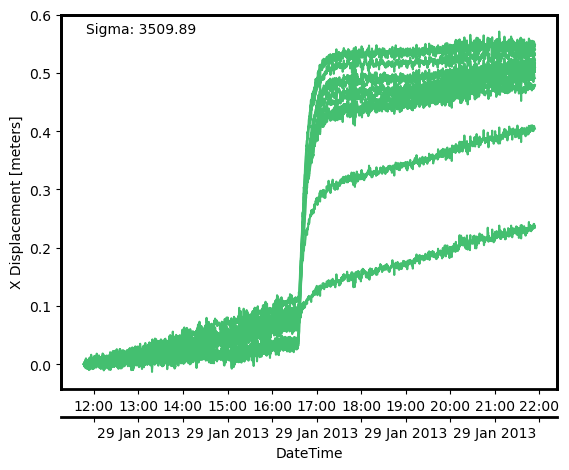

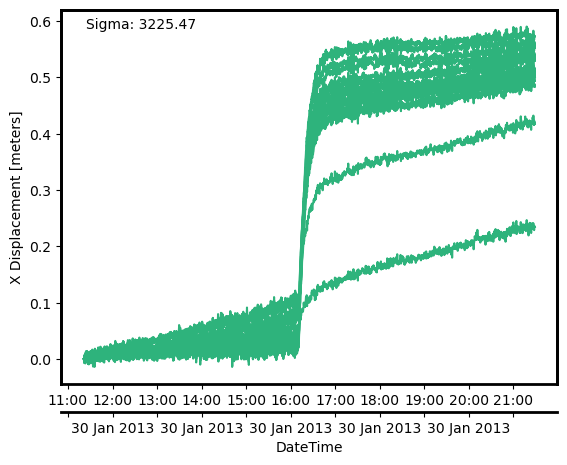

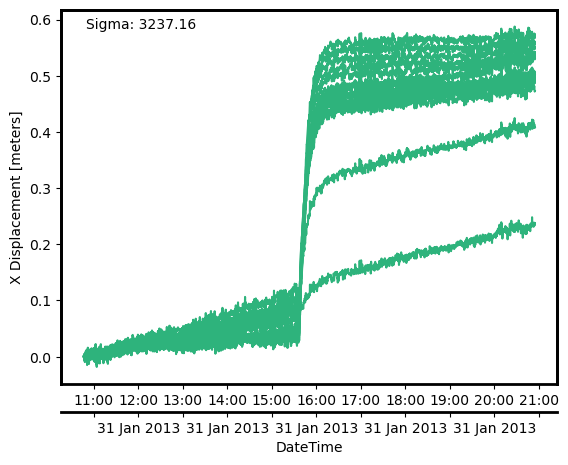

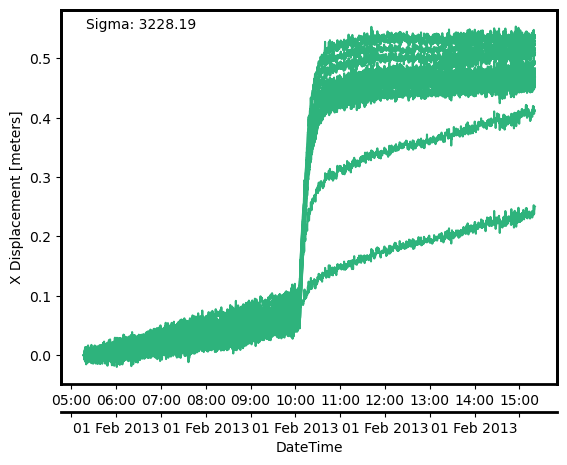

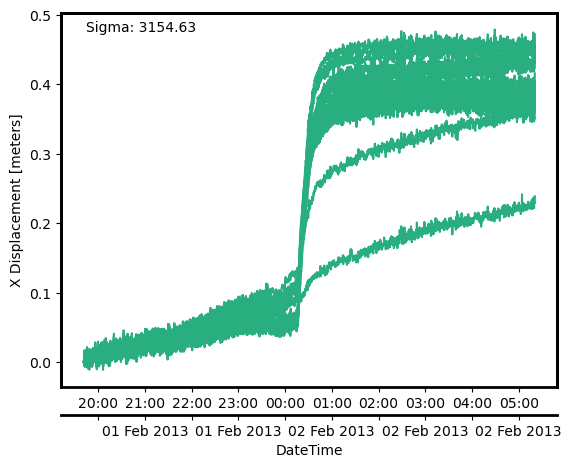

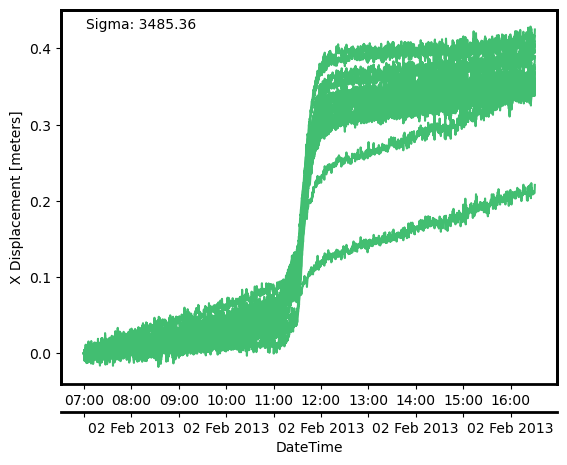

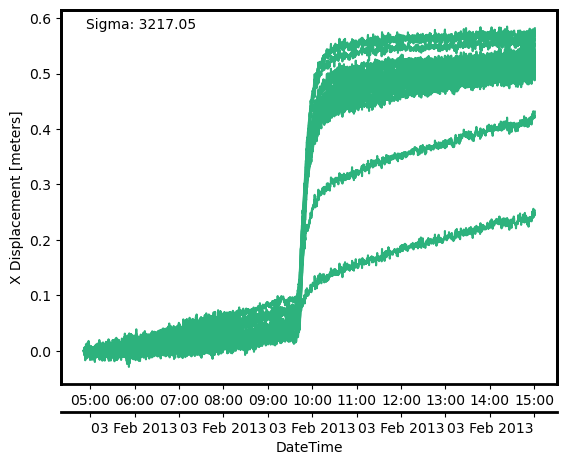

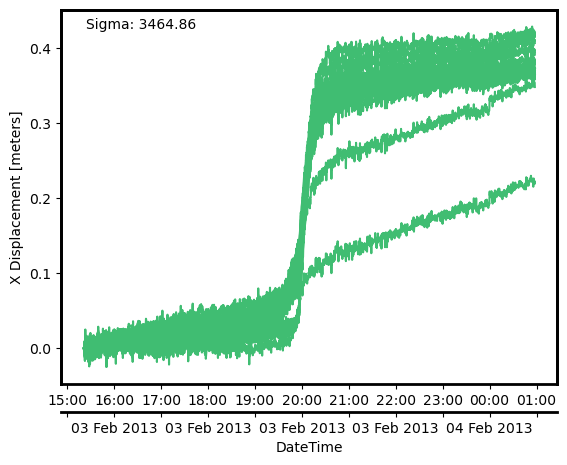

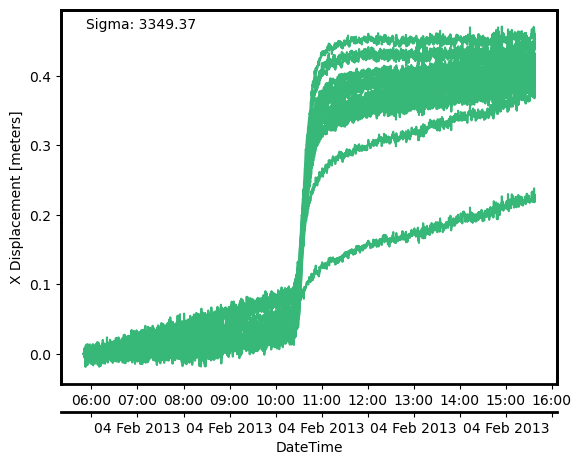

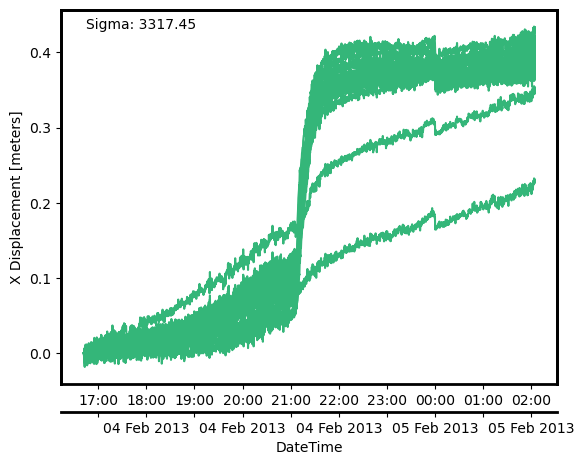

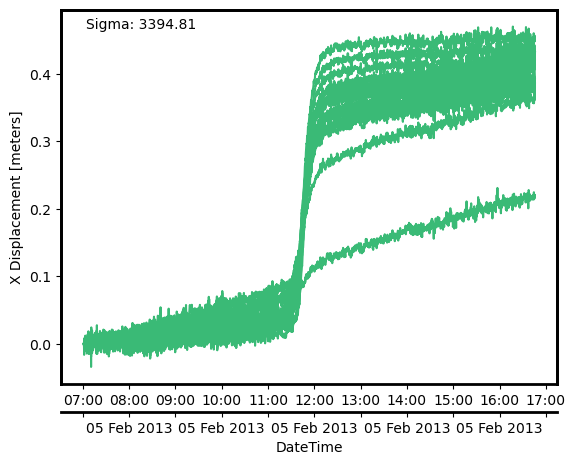

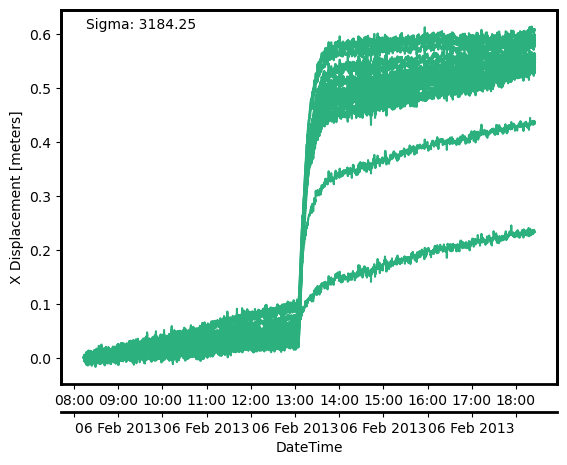

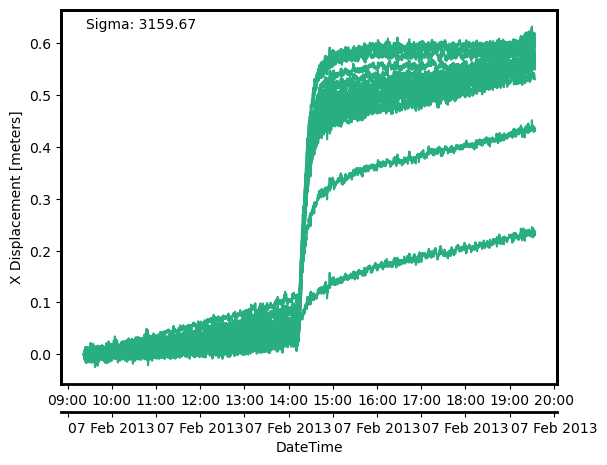

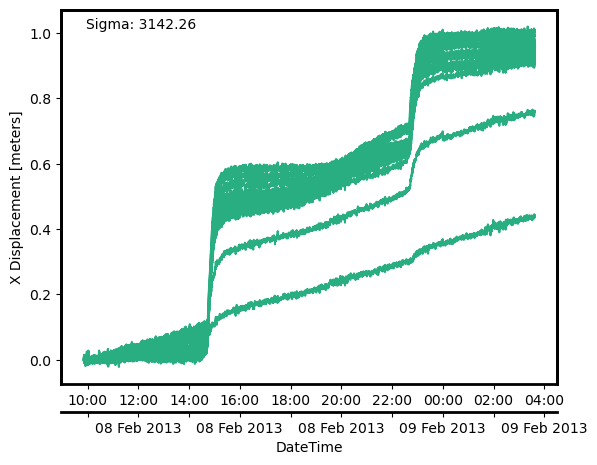

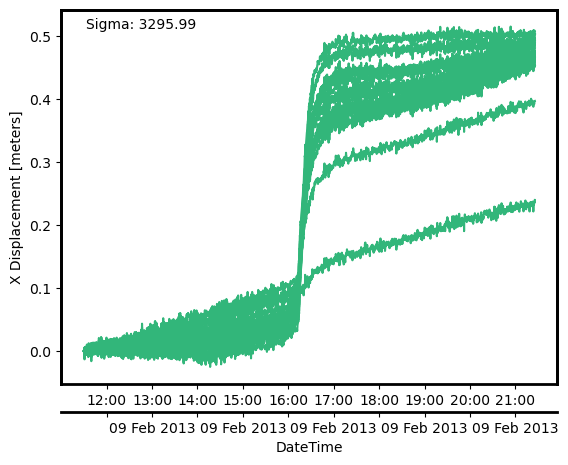

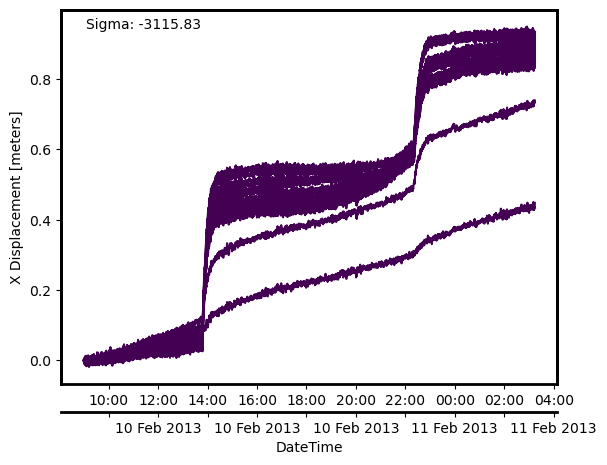

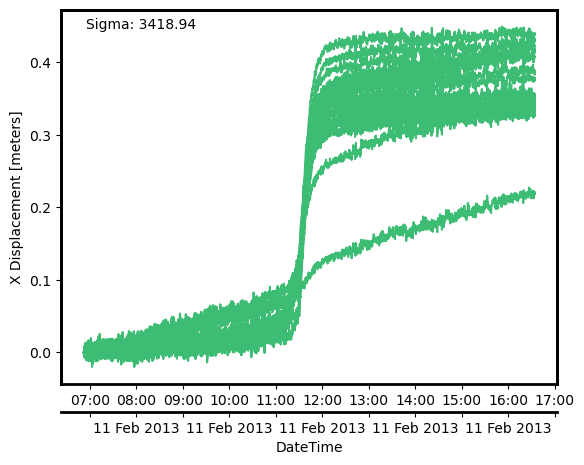

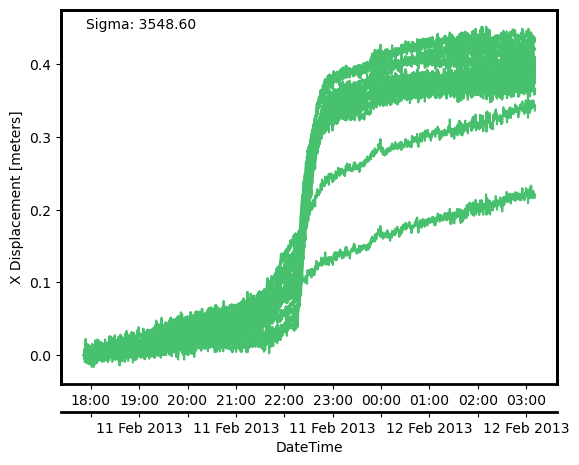

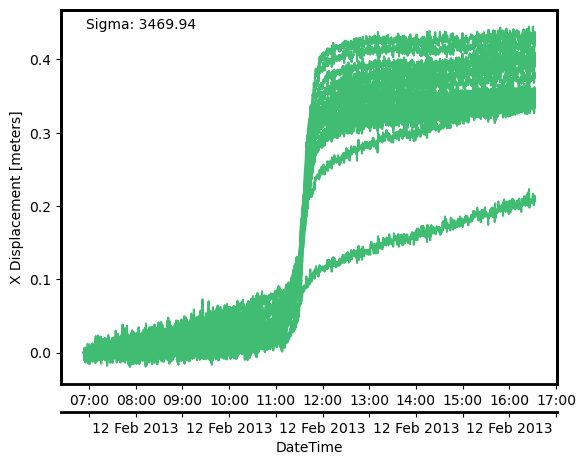

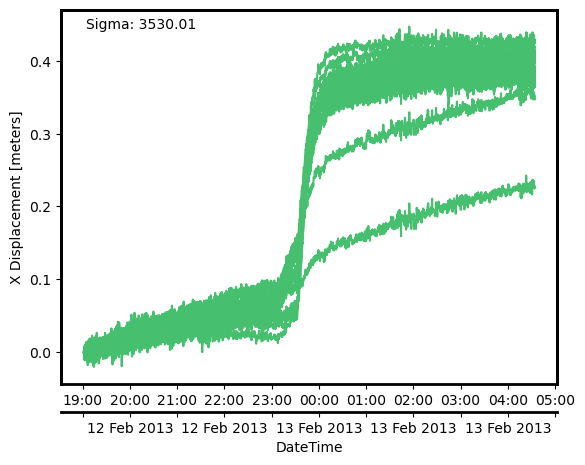

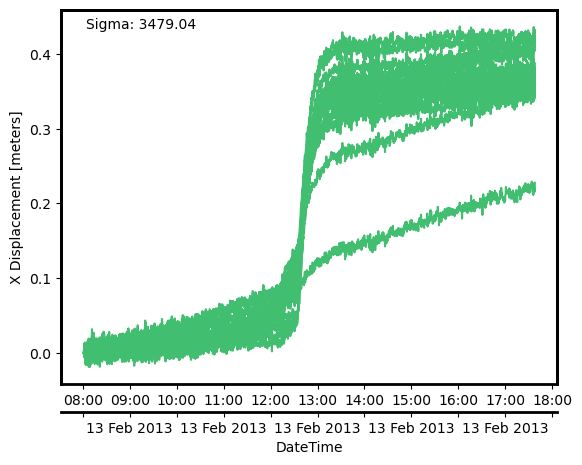

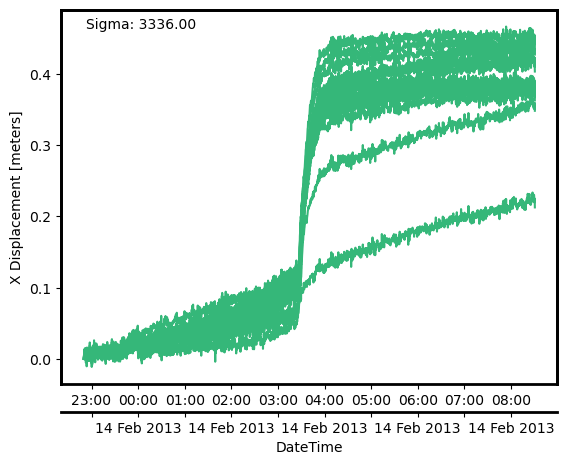

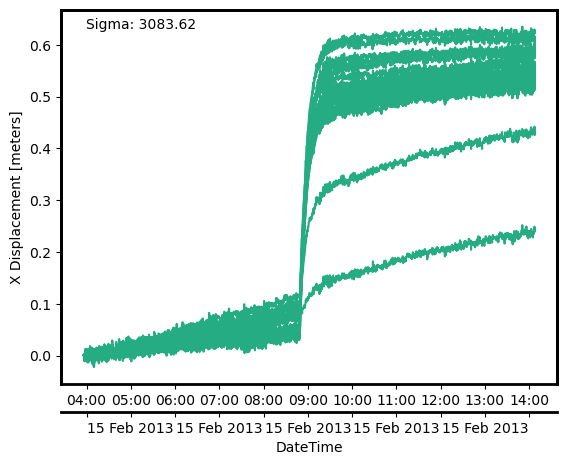

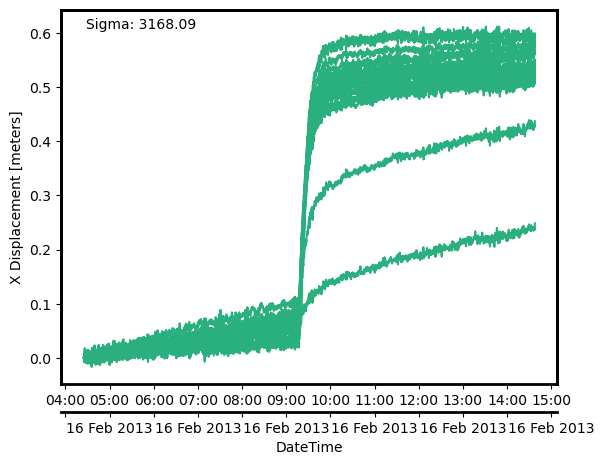

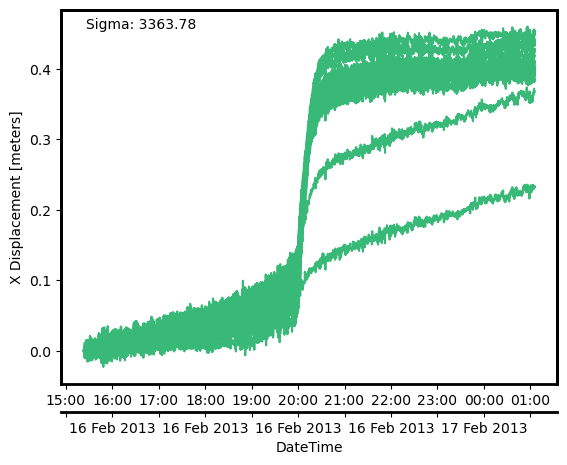

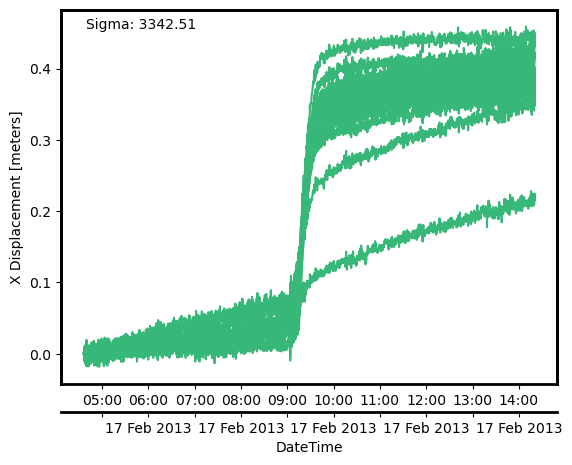

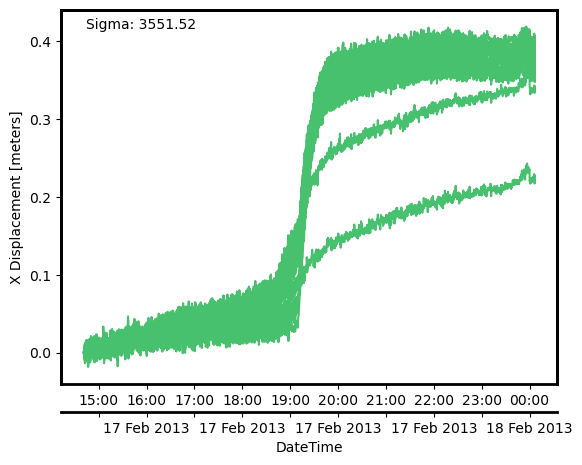

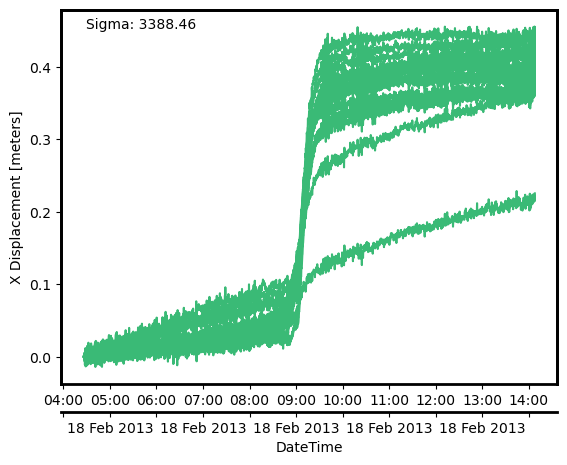

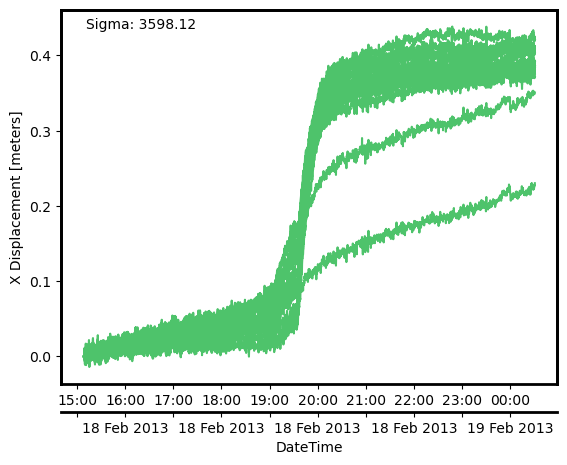

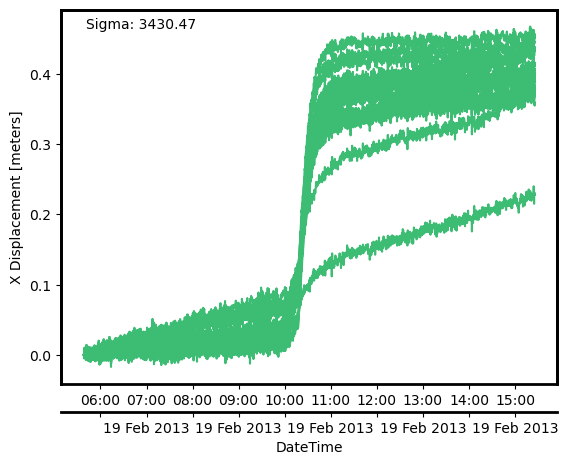

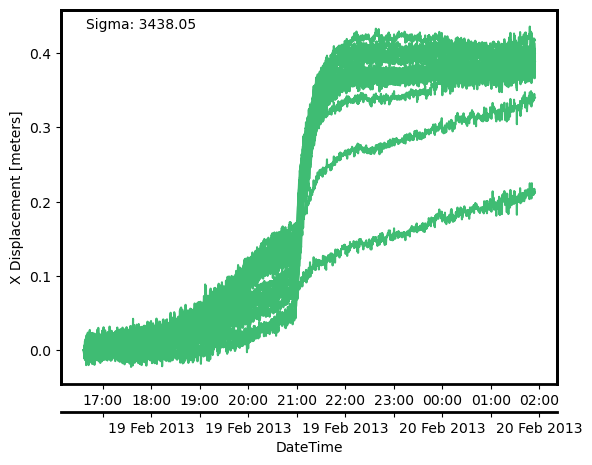

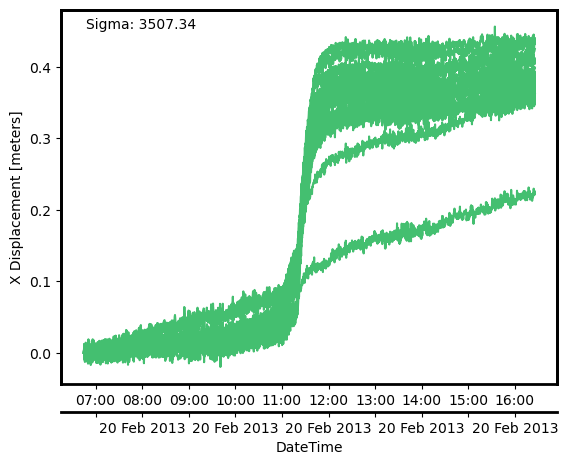

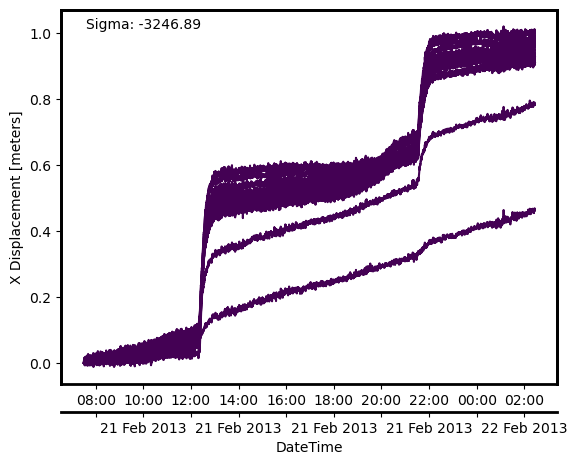

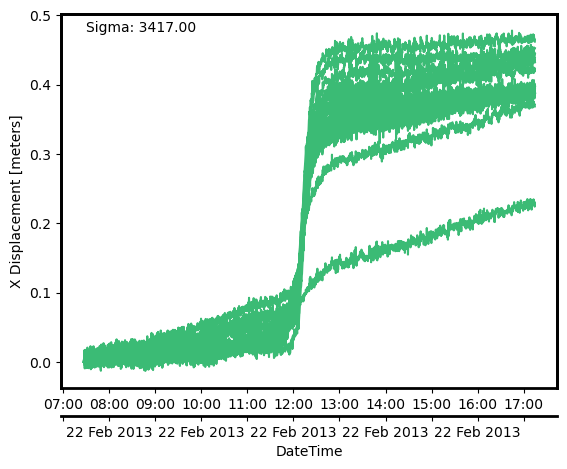

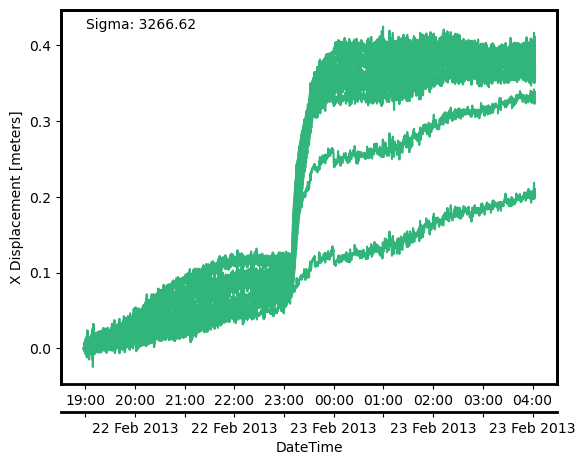

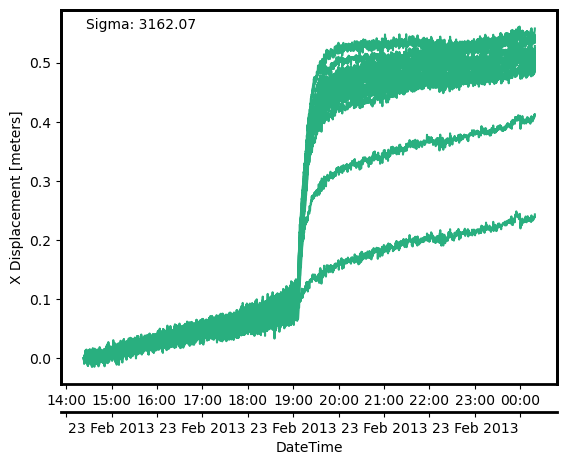

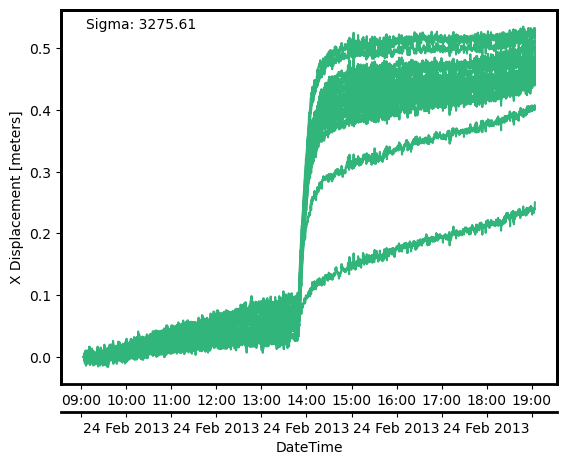

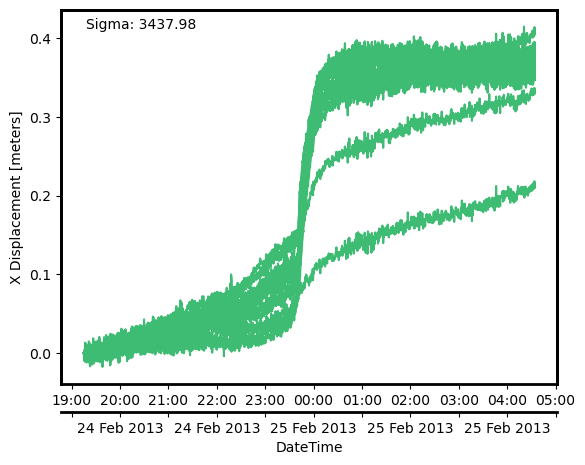

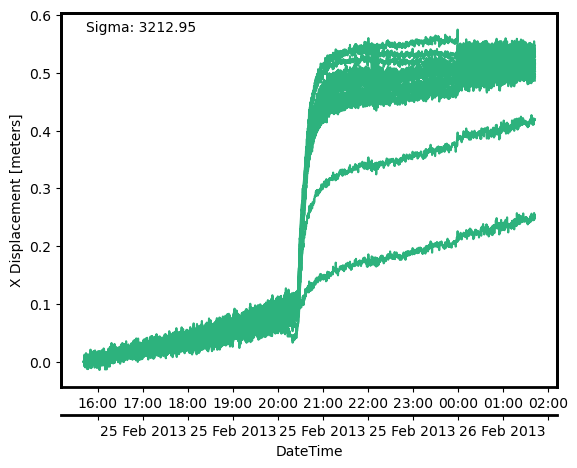

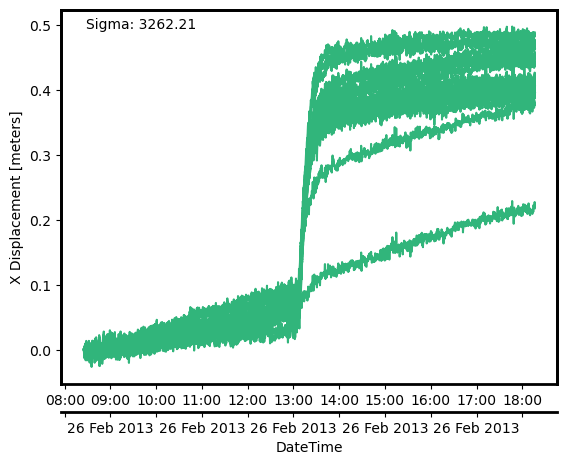

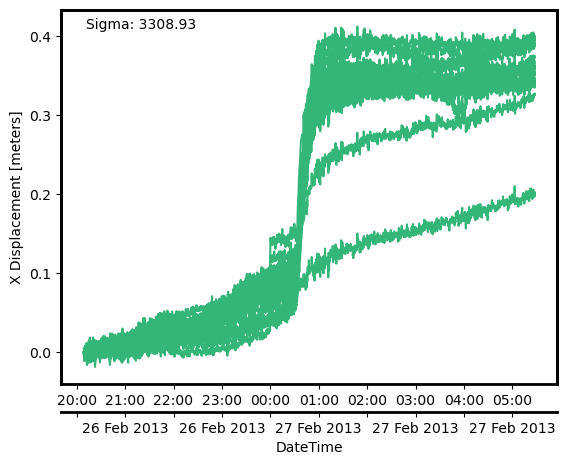

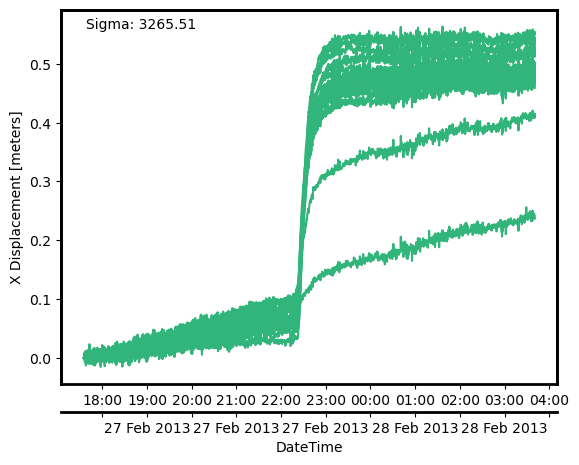

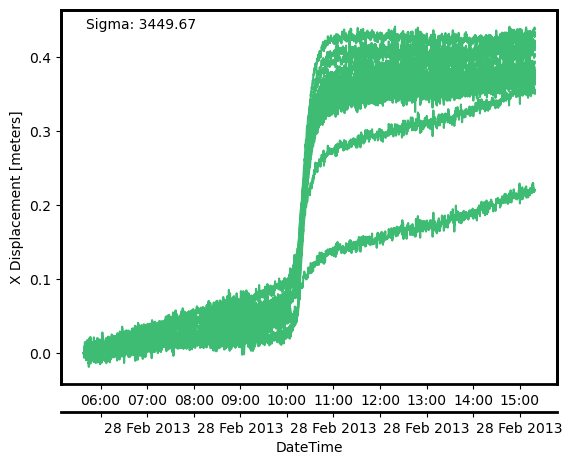

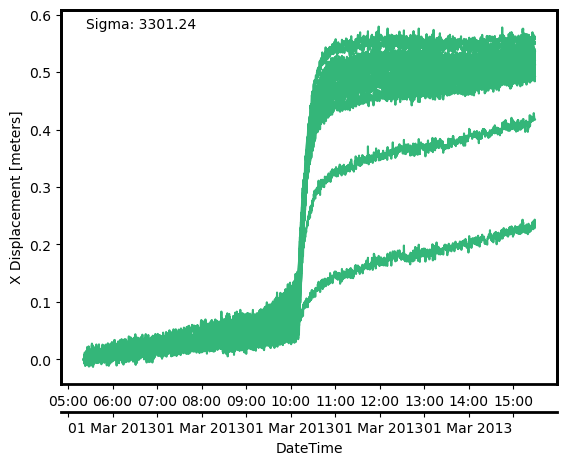

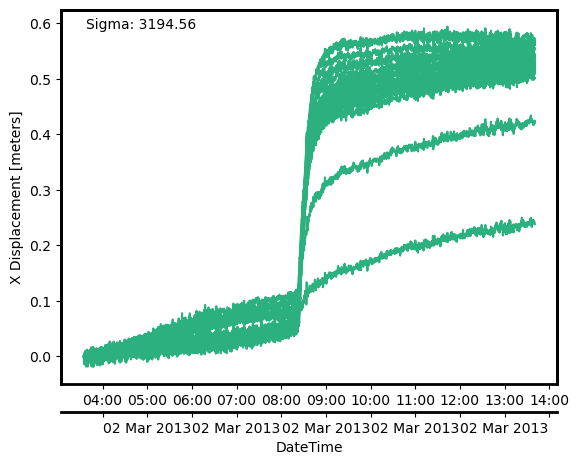

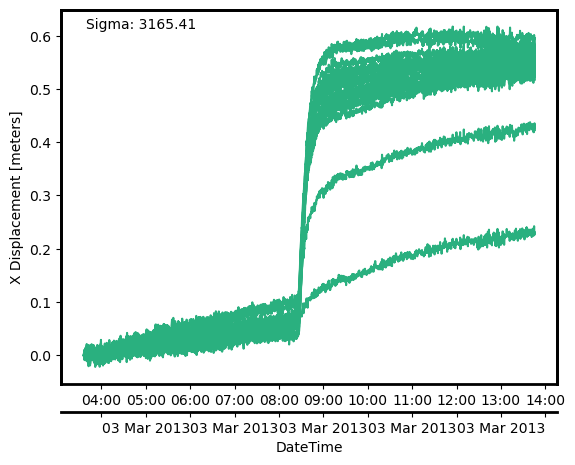

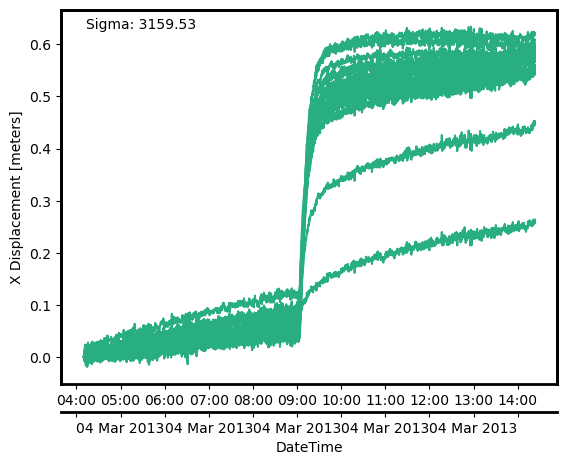

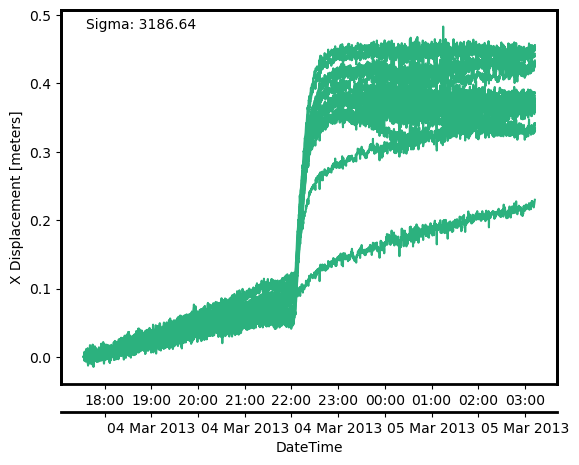

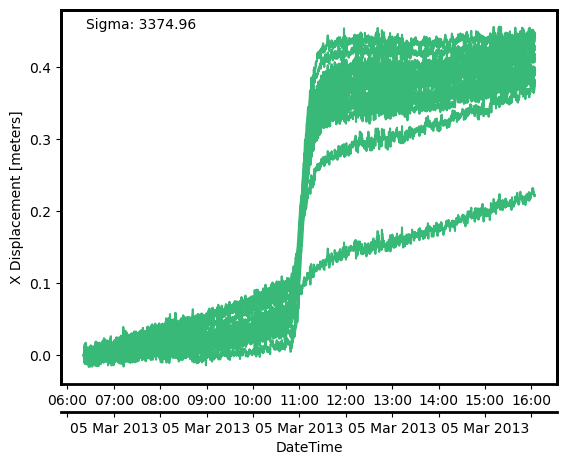

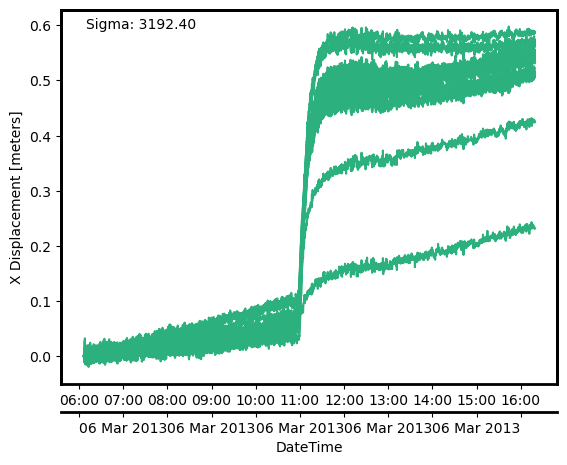

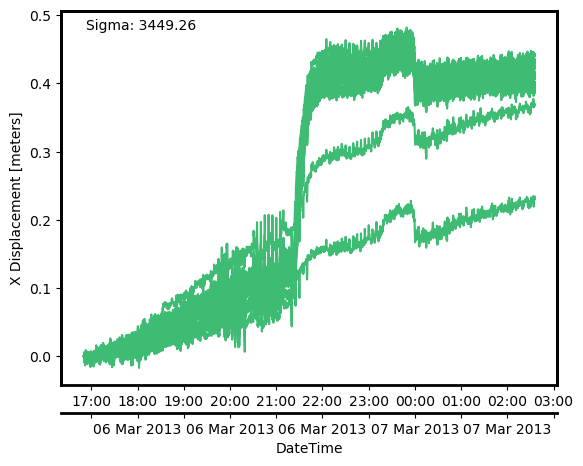

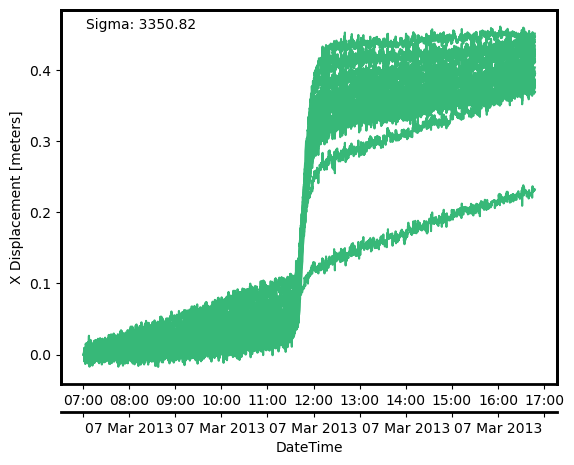

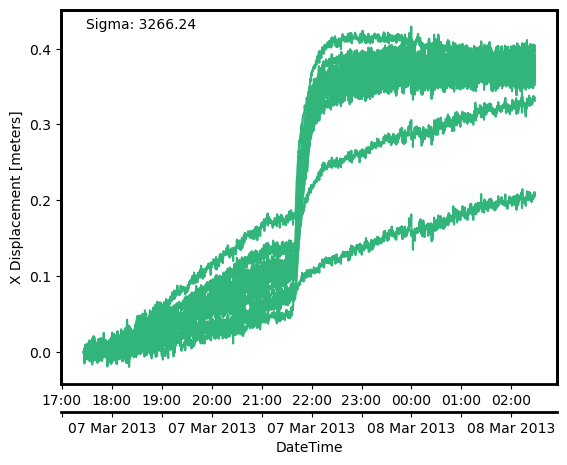

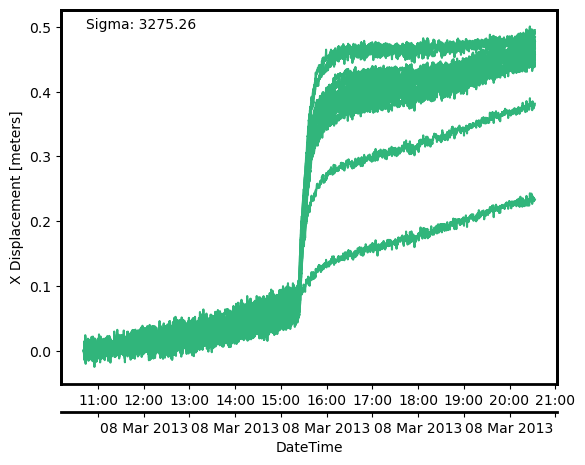

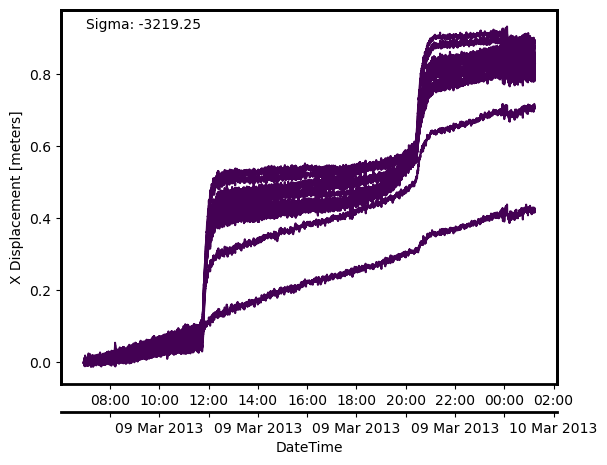

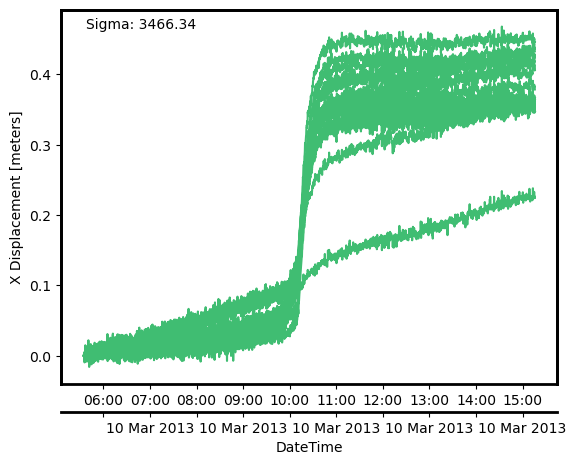

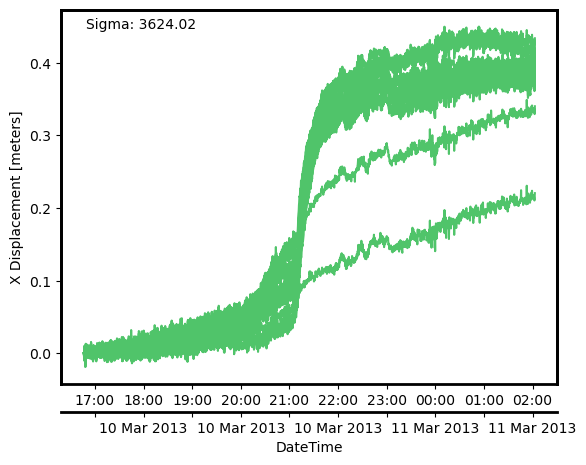

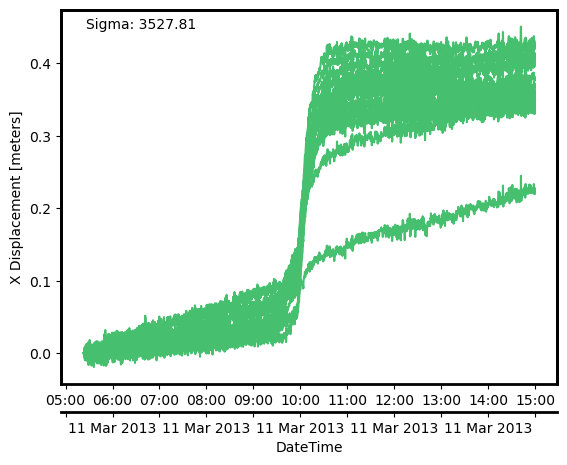

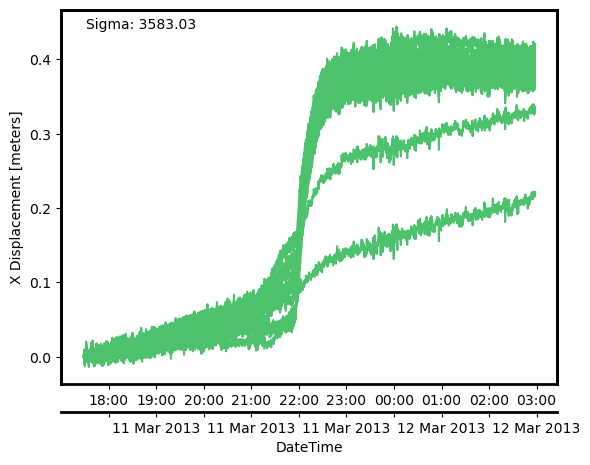

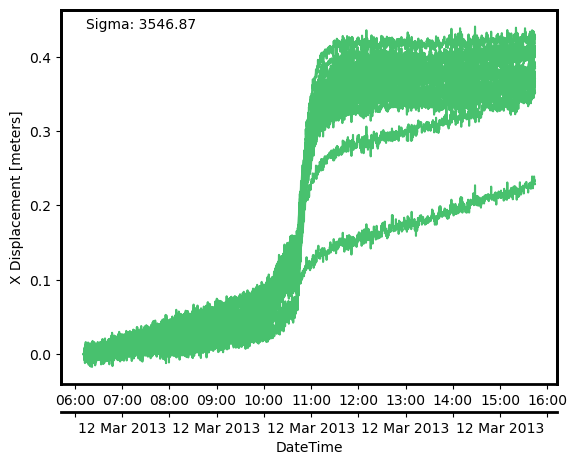

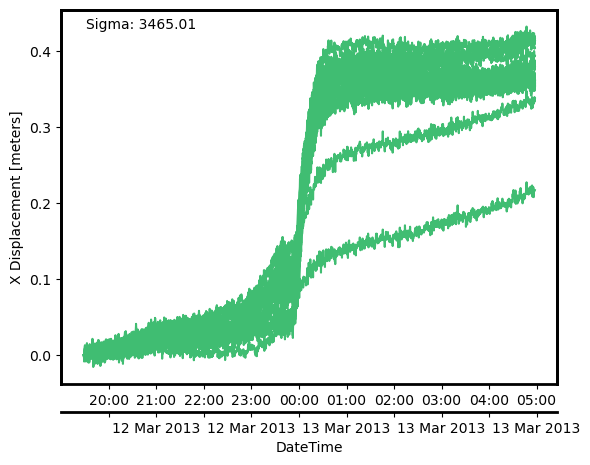

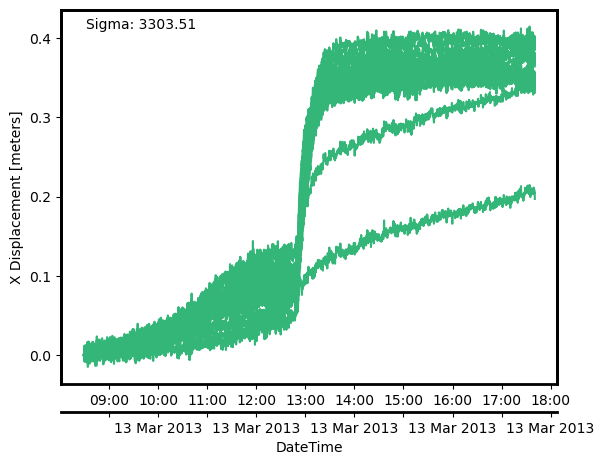

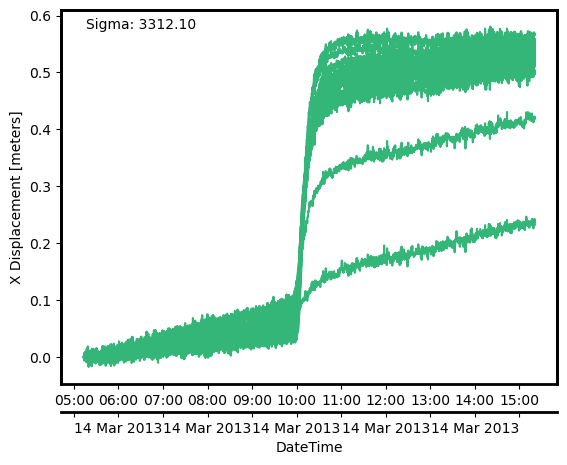

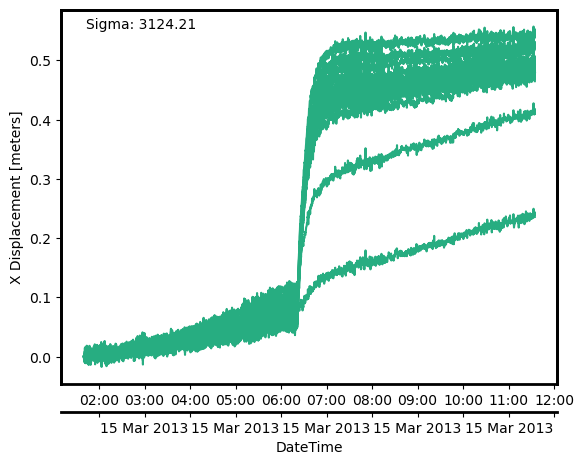

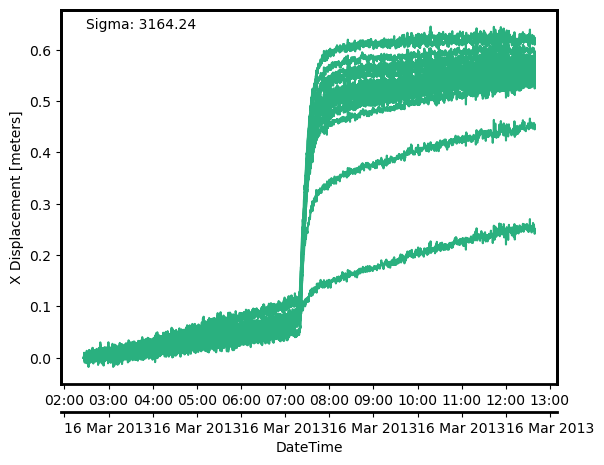

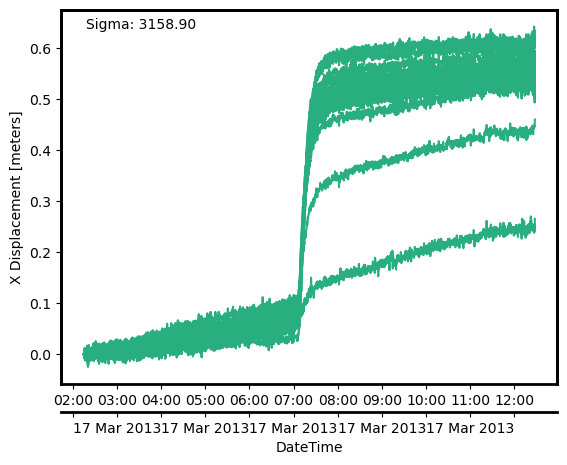

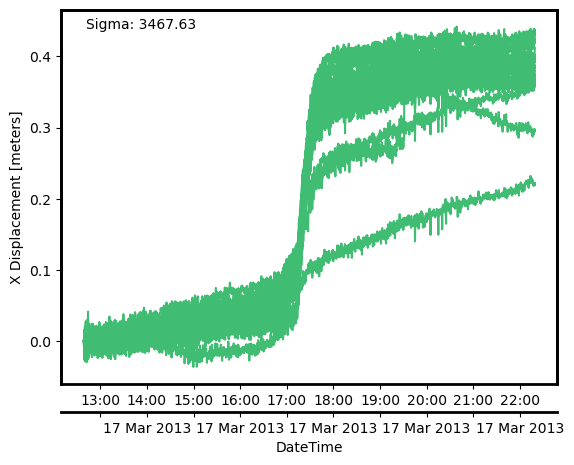

In [67]:
# Plot event and lorentzian fit on top
import numpy as np
import matplotlib.dates as mdates
from matplotlib import cm, colors

vmin = 0
vmax = 5000
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")  # Colormap

for q, event_to_plot in enumerate(catalog[:100]):
    color = cmap(norm(sigma_fits[q]))
    times = pd.to_datetime(event_to_plot["time"])
    # res_cols = [col for col in merged if col.endswith('res')]
    x_cols = [col for col in event_to_plot if str(col).endswith("x")]
    fig, ax1 = plt.subplots()
    first = True
    for i, x_col in enumerate(x_cols):
        demeaned_to_0 = (event_to_plot[x_col] - np.mean(event_to_plot[x_col])) - (
            event_to_plot[x_col][event_to_plot.index[0]] - np.mean(event_to_plot[x_col])
        )
        if not np.isnan(event_to_plot[x_col][event_to_plot.index[0]]):
            if first:
                ax2_dummy = demeaned_to_0
                first = False
            ax1.plot(times, demeaned_to_0, label=str(x_col)[:-1], color=color)
    ax1.set_ylabel("X Displacement [meters]")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.text(
        0.05,
        0.95,
        f"Sigma: {sigma_fits[q]:.2f}",
        transform=ax1.transAxes,
    )
    # ax1.legend()

    # Setup dates using second axis
    ax2 = ax1.twiny()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
    fig.subplots_adjust(bottom=0.10)
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 20))
    ax2.set_xlabel("DateTime")

    # Need to plot something on ax2 to getthe correct dates
    ax2.plot(times, ax2_dummy, alpha=0)
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)